In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import os
import numpy as np
import torch
from pathlib import Path

print(torch.__version__)

1.9.0+cu111


In [4]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
torch.cuda.empty_cache()

In [6]:
# !pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [7]:
import sys

if os.path.join(os.getcwd(), "detr/") not in sys.path:
    sys.path.append(os.path.join(os.getcwd(), "detr/"))
    
print(sys.path)

['/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '', '/home/ammar/projects/.venv/lib/python3.6/site-packages', '/home/ammar/projects/.venv/lib/python3.6/site-packages/IPython/extensions', '/home/ammar/.ipython', '/home/ammar/projects/construction/detr-fine/detr/']


In [8]:
class Args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
a = {'lr': 0.0001, 'lr_backbone': 1e-05, 'batch_size': 1, 'weight_decay': 0.0001, 'epochs': 300, 'lr_drop': 200, 'clip_max_norm': 0.1, 'frozen_weights': False, 'backbone': 'resnet50', 'dilation': False, 'position_embedding': 'sine', 'enc_layers': 6, 'dec_layers': 6, 'dim_feedforward': 2048, 'hidden_dim': 256, 'dropout': 0.1, 'nheads': 8, 'num_queries': 20, 'pre_norm': False, 'masks': True, 'aux_loss': True, 'set_cost_class': 1, 'set_cost_bbox': 5, 'set_cost_giou': 2, 'mask_loss_coef': 1, 'dice_loss_coef': 1, 'bbox_loss_coef': 5, 'giou_loss_coef': 2, 'eos_coef': 0.1, 'dataset_file': 'construction_panoptic', 'data_path': None, 'data_panoptic_path': None, 'remove_difficult': False, 'output_dir': '', 'device': 'cuda', 'resume': '', 'thresh': 0.5}

a['resume'] = '/home/ammar/projects/construction/data/outputs/segmentations/output_all_masks_freezed_150_28_09_2021/checkpoint.pth'

args = Args(**a)

In [9]:
import torch
from  models import build_model

device = torch.device(args.device)

model, _, postprocessors = build_model(args)
model.eval()

if args.resume:
    checkpoint = torch.load(args.resume, map_location='cpu')
    model.load_state_dict(checkpoint['model'])

model.to(device)

print("Model Loaded")

Model Loaded


In [10]:
test_images = [
    'aac_blocks_2273.jpg',
    'aac_blocks_2201.jpg',
    'adhesives_1160.jpg', 
    'ahus_8881.jpg', 
    'aluminium_frames_for_false_ceiling_9505.jpg', 
    'chiller_1119.jpg', 
    'concrete_mixer_machine_7139.jpg',
    'concrete_pump_8290.jpg',
    'concrete_pump_8296.jpg',
    'control_panel_2444.jpg',
    'control_panel_2463.jpg',
    'cu_piping_10001.jpg',
    'cu_piping_10002.jpg',
    'distribution_transformer_7418.jpg',
    'distribution_transformer_7419.jpg',
    'distribution_transformer_7422.jpg',
    'emulsion_paint_3549.jpg',
    'enamel_paint_9171.jpg',
    'fine_aggregate_5220.jpg',
    'fine_aggregate_5247.jpg',
    'fire_buckets_7826.jpg',
    'fire_buckets_7827.jpg',
    'fire_extinguishers_9279.jpg',
    'fire_extinguishers_9291.jpg',
    'glass_wool_1005.jpg',
    'grader_8467.jpg',
    'hoist_2990.jpg',
    'hollow_concrete_blocks_5724.jpg',
    'hot_mix_plant_9548.jpg',
    'hydra_crane_8.jpg',
    'hydra_crane_10.jpg',
    'hydra_crane_14.jpg',
    'interlocked_switched_socket_8919.jpg',
    'junction_box_5765.jpg',
    'lime_5925.jpg',
    'marble_5828.jpg',
    'pipe_fittings_5899.jpg',
    'rcc_hume_pipes_2749.jpg',
    'rcc_hume_pipes_2759.jpg',
    'refrigerant_gas_8373.jpg',
    'river_sand_7246.jpg',
    'rmc_batching_plant_5155.jpg',
    'rmu_units_1053.jpg',
    'sanitary_fixtures_1655.jpg',
    'sanitary_fixtures_1668.jpg',
    'skid_steer_loader_8993.jpg',
    'smoke_detectors_4627.jpg',
    'split_units_108.jpg',
    'split_units_240.jpg',
    'structural_steel_channel_1269.jpg',
    'switch_boards_and_switches_4204.jpg',
    'texture_paint_9230.jpg',
    'texture_paint_9255.jpg',
    'threaded_rod_3602.jpg',
    'transit_mixer_889.jpg',
    'transit_mixer_899.jpg',
    'vcb_panel_4700.jpg',
    'vitrified_tiles_6467.jpg',
    'vitrified_tiles_6471.jpg',
    'vrf_units_2729.jpg',
    'water_tank_6831.jpg',
    'water_tank_6834.jpg',
    'wheel_loader_647.jpg',
    'dump_truck_tipper_truck_802.jpg'
]

In [13]:
import math
import time
import datetime
import io
import itertools
import cv2

from pathlib import Path
from copy import deepcopy

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from PIL import Image, ImageDraw, ImageFont
from panopticapi.utils import id2rgb, rgb2id
from detectron2.utils.visualizer import Visualizer

from datasets.construction import make_construction_transforms
from datasets.categories_meta import id2cat, get_builtin_metadata

palette = itertools.cycle(sns.color_palette())
meta = get_builtin_metadata("construction_panoptic_separated")

# def box_cxcywh_to_xyxy(x):
#     x_c, y_c, w, h = x.unbind(1)
#     b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
#          (x_c + 0.5 * w), (y_c + 0.5 * h)]
#     return torch.stack(b, dim=1)

def rescale_bboxes(box, size):
    iw, ih = size
    
    box = box * torch.Tensor([iw, ih, iw, ih])

    x, y, w, h = box

    return torch.tensor([(x - 0.5 * w), (y - 0.5 * h), (x + 0.5 * w), (y + 0.5 * h)]).cpu()

def load_image(pth, fixed_height=800):
    impath = Path(pth)
    
    imo = Image.open(impath)
    
    height_percent = (fixed_height / float(imo.size[1]))
    width_size = int((float(imo.size[0]) * float(height_percent)))

    imo = imo.resize((width_size, fixed_height))
    iw, ih = imo.size
    
    return imo, iw, ih


def apply_transform(imo, iw, ih, device):
    transform = make_construction_transforms("val")

    dummy_target = {
        "size": torch.as_tensor([int(ih), int(iw)]),
        "orig_size": torch.as_tensor([int(ih), int(iw)])
    }

    image, targets = transform(imo, dummy_target)
    image = image.unsqueeze(0)
    image = image.to(device)
    
    return image


def custom_post_processing(masks, logits, boxes, w, h):
    maps = []
    segments_info = []
    maps_list = []
    sid = 0
    
    for mask, logit, box in zip(masks, logits, boxes):
        segments = {}
        
        cat = logit.argmax()
        if cat < 1:
            continue
        
        box = rescale_bboxes(box, (w, h))
        
        if cat < 17:
            segments['category_id'] = cat.item()
            segments['isthing'] = False
        else:
            segments['category_id'] = cat.item()
            segments['isthing'] = True
        
        segments['area'] = ((box[2]-box[0]) * (box[3]-box[1])).item()

        maps_list.append((mask, logit, box))
        segments['id'] = sid
        sid += 1
        segments_info.append(segments)
        maps.append(torch.tensor(mask))

    if len(maps) == 1:
        maps.append(torch.zeros_like(maps[0]))

    combined_maps = torch.argmax(torch.stack(maps), dim=0).numpy()
    combined_maps = cv2.resize(combined_maps, (w, h), interpolation=cv2.INTER_NEAREST)

    for idx, (_, _, box) in enumerate(maps_list):
        white_mask = np.zeros_like(combined_maps)
        white_mask[...] = 255
        x1,y1,x2,y2 = map(int, box.numpy())
        white_mask[y1:y2, x1:x2] = combined_maps[y1:y2, x1:x2]
        combined_maps = np.where(combined_maps==idx, white_mask, combined_maps)
        
    return combined_maps, segments_info


def run_prediction(model, image, postprocessors, device, threshold=0.85):
    outputs = model.to(device)(image)
    
    postprocessors['panoptic'].threshold = threshold
    panoptic = postprocessors['panoptic'](outputs, torch.as_tensor(image.shape[-2:]).unsqueeze(0))[0]

    logits = outputs["pred_logits"].cpu()
    boxes = outputs["pred_boxes"].cpu()
    masks = outputs["pred_masks"].cpu()
    
    scores = logits.softmax(-1)[..., :-1].max(-1)[0]
    
    # threshold the confidence, filter all predictions above threshod
    keep = scores > threshold
    
    return scores[keep], logits[keep], boxes[keep], masks[keep].detach().numpy(), panoptic
    

def overlay_boxes(img, iw, ih, scores, logits, boxes, debug=False):
    imn = img.copy()
    drw = ImageDraw.Draw(imn)
    font = ImageFont.load_default() # ImageFont.truetype("arial")

    for score, logit, box in zip(scores, logits, boxes):
        cat = logit.argmax()
        if cat < 1:
            continue

        label = f'{id2cat[cat.item()]} ({score:.2f})'
        box = box * torch.Tensor([iw, ih, iw, ih])

        x, y, w, h = box
        
        # x0, x1 = x-w//2, x+w//2
        # y0, y1 = y-h//2, y+h//2
        rbbox = torch.tensor([(x - 0.5 * w), (y - 0.5 * h), (x + 0.5 * w), (y + 0.5 * h)]).cpu()

        rbbox[0::2].clamp_(min=0, max=torch.tensor(iw))
        rbbox[1::2].clamp_(min=0, max=torch.tensor(ih))
        
        if debug:
            print(label, rbbox)

        drw.rectangle(list(rbbox), outline='red', width=3)
        # drw.text((rbbox[0]+4, rbbox[1]+2), label, fill='white')

        # get text size
        text_size = font.getsize(label)
        # set button size + 10px margins
        label_size = (text_size[0]+6, text_size[1]+6)
        # create image with correct size and black background
        label_img = Image.new('RGBA', label_size, "green")
        # put text on button with 10px margins
        label_draw = ImageDraw.Draw(label_img)
        label_draw.text((3, 3), label, font=font, fill='white')

        # put text on source image in position (x+2, y+2)
        imn.paste(label_img, (rbbox[0]+2, rbbox[1]+2))
        
    return imn


def get_panoptic_mask(panoptic):
    # The segmentation is stored in a special-format png
    panoptic_seg = Image.open(io.BytesIO(panoptic['png_string']))

    # Convert to numpy array
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()

    # We retrieve the ids corresponding to each mask
    panoptic_seg_id = rgb2id(panoptic_seg)

    # Finally we color each mask individually
    panoptic_seg[:, :, :] = np.asarray(next(palette)) * 255
    for sid in range(panoptic_seg_id.max() + 1):
        panoptic_seg[panoptic_seg_id == sid] = np.asarray(next(palette)) * 255
        
    return panoptic_seg


def get_custom_panoptic_overlay(imo, combined_maps, segments_info):
#     # The segmentation is stored in a special-format png
#     panoptic_seg = Image.open(io.BytesIO(panoptic['png_string']))
    ph, pw = combined_maps.shape

#     # Convert to numpy array
#     panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()

    # We retrieve the ids corresponding to each mask
    panoptic_seg_id = combined_maps
    
    panoptic_seg_id_tensor = torch.from_numpy(panoptic_seg_id)
    segments_info = deepcopy(segments_info)

    for i in range(len(segments_info)):
        c = segments_info[i]["category_id"]
        segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

    # Finally we visualize the prediction
    visualize = Visualizer(np.array(imo.copy().resize((pw, ph)))[:, :, ::-1], meta, scale=1.0)
    visualize._default_font_size = 20
    visualize = visualize.draw_panoptic_seg_predictions(panoptic_seg_id_tensor, segments_info, area_threshold=0)
    overlayed = visualize.get_image()
    
    return overlayed


def get_panoptic_overlay(imo, panoptic):
    # The segmentation is stored in a special-format png
    panoptic_seg = Image.open(io.BytesIO(panoptic['png_string']))
    pw, ph = panoptic_seg.size

    # Convert to numpy array
    panoptic_seg = np.array(panoptic_seg, dtype=np.uint8).copy()

    # We retrieve the ids corresponding to each mask
    panoptic_seg_id = rgb2id(panoptic_seg)
    
    panoptic_seg_id_tensor = torch.from_numpy(panoptic_seg_id)
    segments_info = deepcopy(panoptic["segments_info"])

    for i in range(len(segments_info)):
        c = segments_info[i]["category_id"]
        segments_info[i]["category_id"] = meta.thing_dataset_id_to_contiguous_id[c] if segments_info[i]["isthing"] else meta.stuff_dataset_id_to_contiguous_id[c]

    # Finally we visualize the prediction
    visualize = Visualizer(np.array(imo.copy().resize((pw, ph)))[:, :, ::-1], meta, scale=1.0)
    visualize._default_font_size = 20
    visualize = visualize.draw_panoptic_seg_predictions(panoptic_seg_id_tensor, segments_info, area_threshold=0)
    overlayed = visualize.get_image()
    
    return overlayed


def get_masks(logits, masks):
    mask_array = []
    
    for logit, mask in zip(logits, masks):
        cat = logit.argmax()
        if cat < 1:
            continue

        mask_array.append({
            'mask': mask,
            'label': f'{id2cat[cat.item()]}'
        })
    
    return mask_array   
    

def get_prediction(pth, model, threshold, device, debug=False):
    start = time.time()
    
    result = {}
    
    # Load image with path provided
    imo, iw, ih = load_image(pth)
    
    result["original_image"] = imo
    
    # Apply transform to normalize and convert to tensor
    image = apply_transform(imo, iw, ih, device)

    # Run prediction and threshold output
    scores, logits, boxes, masks, panoptic = run_prediction(model, image, postprocessors, device, threshold)
    
    combined_maps, segments_info = custom_post_processing(masks, logits, boxes, iw, ih)
    
    result["boxed_image"] = overlay_boxes(imo, iw, ih, scores, logits, boxes, debug=debug)
    
    result["mask_images"] = get_masks(logits, masks)
    
    result["panoptic_mask"] = get_panoptic_mask(panoptic)
    
    result["panoptic_image"] = get_panoptic_overlay(imo, panoptic)
    
    result["custom_panoptic_image"] = get_custom_panoptic_overlay(imo, combined_maps, segments_info)
    
    print(f"Time Taken: {datetime.timedelta(seconds=int(time.time() - start))}")
    
    return result, logits, boxes, masks # keep, pred_logits, pred_masks.detach().numpy(), imn, result_panoptic


def visualize_masks(masks):
    # Plot all the remaining masks
    if len(masks) == 1:
        plt.imshow(masks[0]["mask"], cmap="cividis")
        # plt.set_title(f'{id2cat[pred_logits[1].argmax().item()]}', {'fontsize': 15})
        plt.axis('off')
    elif len(masks) == 2:
        _, axarr = plt.subplots(1,2, figsize=(10, 10))

        for i, ax in enumerate(axarr):
            ax.imshow(masks[i]["mask"], cmap="cividis")
            ax.set_title(f'{masks[i]["label"]}', {'fontsize': 15})
            ax.axis('off')
    else:
        ncols = 2
        fig, axs = plt.subplots(ncols=ncols, nrows=math.ceil(len(masks) / ncols), figsize=(15, 10))
#         for aa in axs:
#             for ax in aa:
#                 ax.axis('off')
        for i, mask in enumerate(masks):
            ax = axs[i // ncols, i % ncols]
            ax.imshow(mask["mask"], cmap="cividis")
            ax.set_title(mask["label"], {'fontsize': 15})
            ax.axis('off')
        fig.tight_layout()

    plt.show()
    
def visualize_predictions(result, save_result=False, name='result.png'):
    _, axarr = plt.subplots(2, 2, figsize=(20,10))

    axarr[0][0].imshow(result["original_image"])
    axarr[0][0].set_title('Input Image', {'fontsize': 15})
    axarr[0][0].axis('off')

    axarr[0][1].imshow(result["boxed_image"])
    axarr[0][1].set_title('Boxed Image', {'fontsize': 15})
    axarr[0][1].axis('off')

    # axarr[2].imshow(Image.open(f"../data/panoptic/{iname.split('.')[0]}.png"))
    # axarr[2].set_title('Target Mask', {'fontsize': 15})
    # axarr[2].axis('off')

    axarr[1][0].imshow(result["panoptic_mask"])
    axarr[1][0].axis('off')
    axarr[1][0].set_title('Predicted Mask', {'fontsize': 15})

    axarr[1][1].imshow(result["panoptic_image"])
    axarr[1][1].axis('off')
    axarr[1][1].set_title('Overlayed', {'fontsize': 15})

    if save_result:
        plt.savefig(f"../data/predictions/{name}", bbox_inches='tight')

    plt.show()

Time Taken: 0:00:01


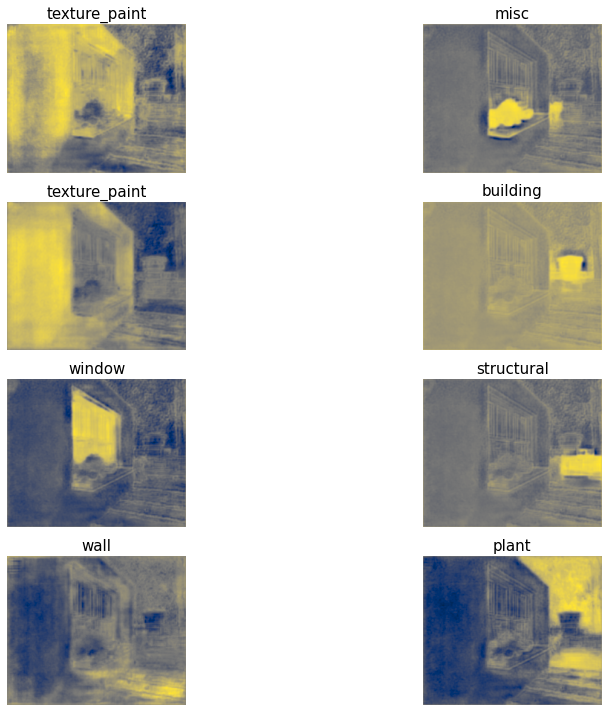

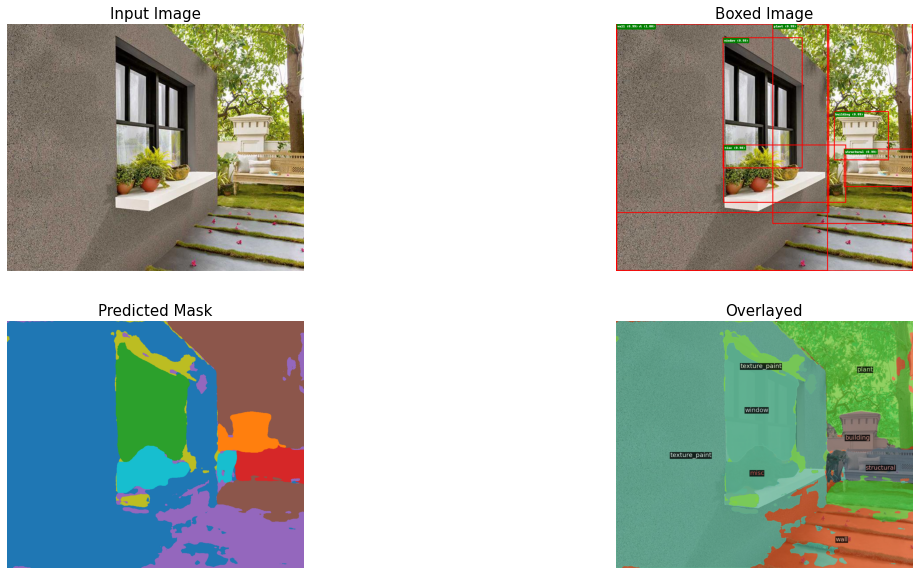

In [30]:
iname = 'texture_paint_9255.jpg'

# Get Results
result, logits, boxes, masks = get_prediction(f'../../construction/data/images/{iname}', model, 0.85, device, debug=False)

# result = get_prediction(f'../../construction/data/construction_test/test3.jpg', model, 0.80, device, debug=False)

# Show Masks
visualize_masks(result["mask_images"])

# Show Predictions
visualize_predictions(result)

In [109]:
import cv2
import os

import PIL
from PIL import Image, ImageOps

def resize_with_pad(im, desired_size=800):
    
    if type(im) != PIL.Image.Image:
        im = Image.fromarray(im).convert('RGB')

    old_size = im.size  # old_size[0] is in (width, height) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    # use thumbnail() or resize() method to resize the input image

    # thumbnail is a in-place operation

    # im.thumbnail(new_size, Image.ANTIALIAS)

    im = im.resize(new_size, Image.ANTIALIAS)
    # create a new image and paste the resized on it

    new_im = Image.new("RGB", (desired_size, desired_size))
    new_im.paste(im, ((desired_size-new_size[0])//2,
                        (desired_size-new_size[1])//2))

    return np.asarray(new_im)


video_name = '../data/construction.mp4'

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
video = cv2.VideoWriter(video_name, 0x7634706d, 1, (800, 800))

for ti in test_images:
    result, logits, boxes, masks = get_prediction(f'../../construction/data/images/{ti}', model, 0.80, device, debug=False)
    video.write(cv2.cvtColor(resize_with_pad(result["original_image"]), cv2.COLOR_RGB2BGR))
    video.write(cv2.cvtColor(resize_with_pad(result["boxed_image"]), cv2.COLOR_RGB2BGR))
#     video.write(cv2.cvtColor(resize_with_pad(result["panoptic_mask"]), cv2.COLOR_RGB2BGR))
#     video.write(cv2.cvtColor(resize_with_pad(result["custom_panoptic_image"]), cv2.COLOR_RGB2BGR))
    video.write(cv2.cvtColor(resize_with_pad(result["panoptic_image"]), cv2.COLOR_RGB2BGR))

video.release()

Time Taken: 0:00:01
Time Taken: 0:00:03
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:02
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:02
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:02
Time Taken: 0:00:00
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01
Time Taken: 0:00:01


In [102]:
torch.cuda.empty_cache()

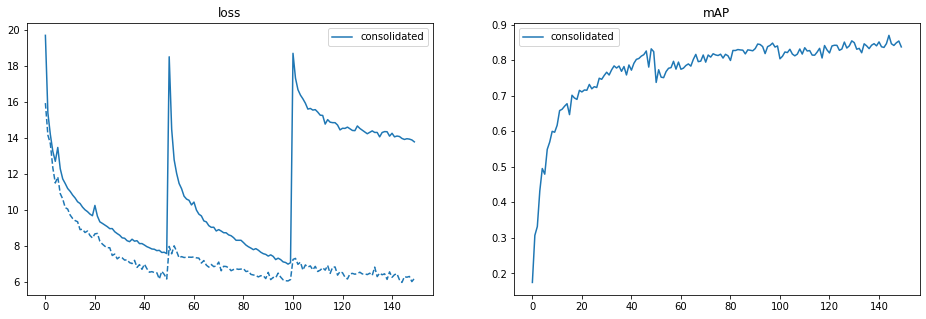

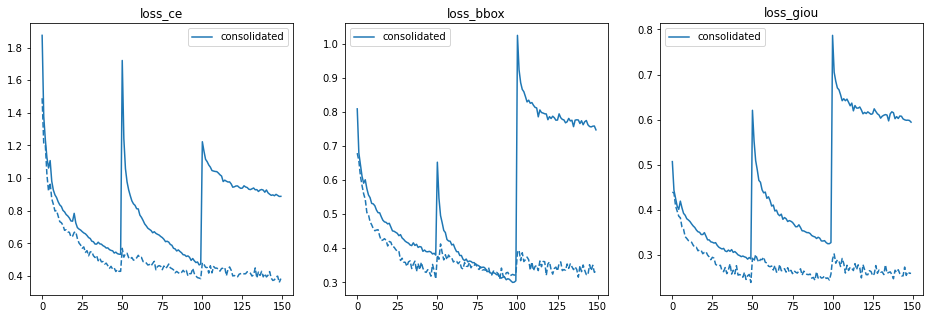

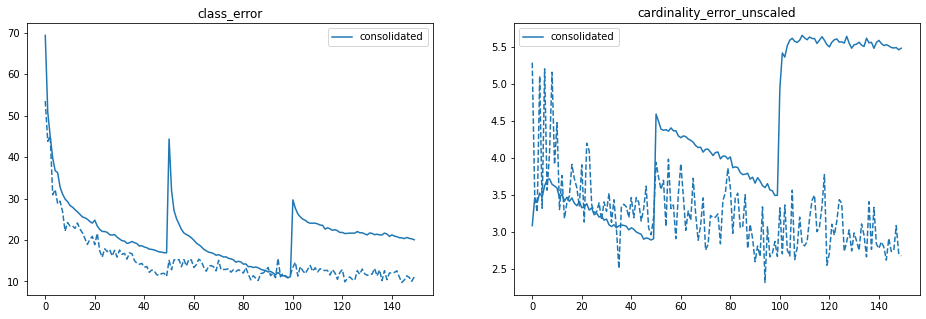

In [27]:
from util.plot_utils import plot_logs

from pathlib import Path

log_directory = [
    Path('../data/outputs/boxes/consolidated'), 
]

plot_logs(log_directory, (
    'loss',
    'mAP',
))

plot_logs(log_directory, (
    'loss_ce',
    'loss_bbox',
    'loss_giou',
))

plot_logs(log_directory, (
    'class_error',
    'cardinality_error_unscaled',
))

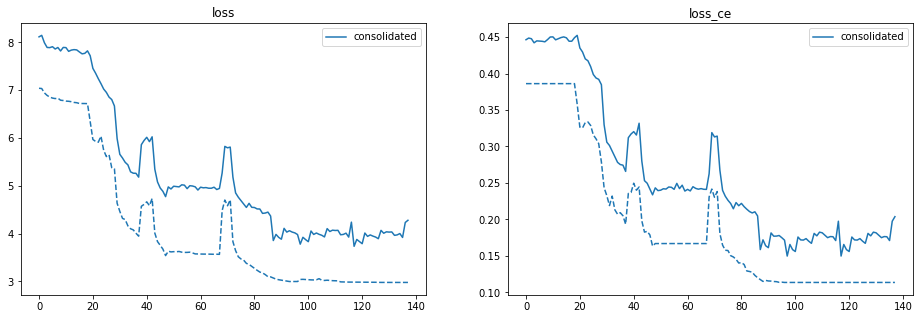

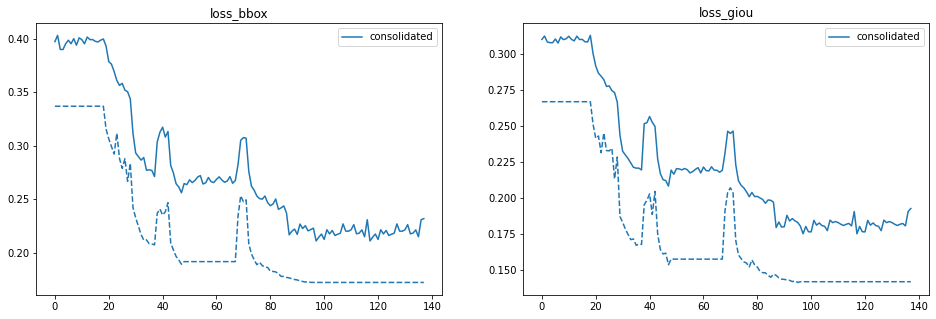

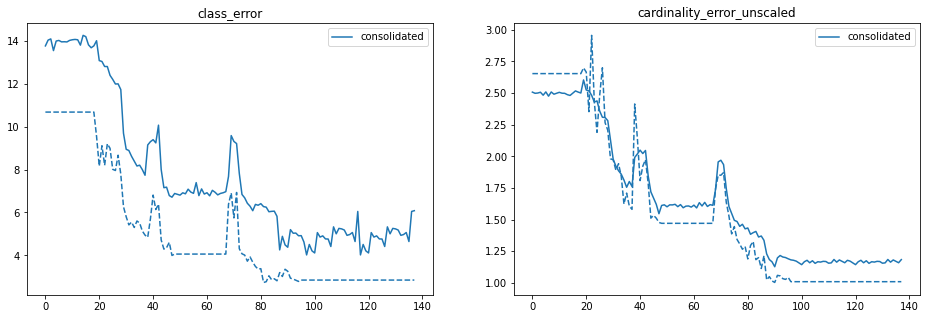

In [31]:
from util.plot_utils import plot_logs, plot_precision_recall

from pathlib import Path

log_directory = [
#     Path('../data/outputs/boxes/output_all_5_08_09_2022'), 
#     Path('../data/outputs/boxes/output_all_20_08_09_2022'), 
#     Path('../data/outputs/boxes/output_all_50_09_09_2022'), 
#     Path('../data/outputs/boxes/output_all_60_13_09_2022'), 
#     Path('../data/outputs/boxes/output_all_100_14_09_2022'), 
#     Path('../data/outputs/boxes/output_all_150_19_09_2022'), 
    Path('../data/outputs/segmentations/consolidated'),
]

log_files = [
#     Path('../data/outputs/boxes/output_all_5_08_09_2022'), 
#     Path('../data/outputs/boxes/output_all_20_08_09_2022'), 
#     Path('../data/outputs/boxes/output_all_50_09_09_2022'), 
#     Path('../data/outputs/boxes/output_all_60_13_09_2022'), 
#     Path('../data/outputs/boxes/output_all_100_14_09_2022'), 
#     Path('../data/outputs/boxes/output_all_150_19_09_2022'), 
    Path('../data/outputs/segmentations/consolidated/log.txt')
]

# plot_logs(log_directory, (
#     'loss',
#     'mAP',
# ))

plot_logs(log_directory, (
    'loss',
    'loss_ce'
))

plot_logs(log_directory, (
    'loss_bbox',
    'loss_giou',
))

plot_logs(log_directory, (
    'class_error',
    'cardinality_error_unscaled',
))

# plot_precision_recall(log_files)